In [23]:
pdb_path=r'D:\PythonProj\Auto-EC\pdb_files\1FT5.pdb'

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

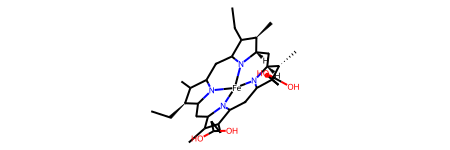

In [24]:
import os
import numpy as np
from Bio.PDB import PDBParser, PDBIO, Select
import tempfile
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

def save_selected_pdb(structure, ligand_info, interacting_residues, output_pdb):
    class LigandAndInteractingResiduesSelect(Select):
        def accept_residue(self, residue):
            if (residue.resname == ligand_info['name'] and residue.id == ligand_info['id'] and residue.parent.id == ligand_info['chain']):
                return True
            for res in interacting_residues:
                if residue.resname == res['residue'] and residue.id[1] == res['id'] and residue.parent.id == res['chain']:
                    return True
            return False
    
    io = PDBIO()
    io.set_structure(structure)
    io.save(output_pdb, LigandAndInteractingResiduesSelect())
    
def get_ligands_and_interactions(pdb_path):
    """
    Identify all ligands in PDB file.
    
    Args:
        pdb_path: Path to PDB file
        
    Returns:
        structure: Parsed PDB structure
        ligands_info: List of dictionaries with ligand information
    """
    # Parse PDB file
    parser = PDBParser(QUIET=True)
    structure_id = os.path.basename(pdb_path).split('.')[0]
    structure = parser.get_structure(structure_id, pdb_path)
    model = structure[0]
    
    ligands_info = []
    for chain in model:
        for residue in chain:
            if residue.id[0] != ' ' :
                # Get ligand info
                ligand_info = {
                    'chain': chain.id,
                    'id': residue.id,
                    'name': residue.resname,
                    'atoms': len(residue),
                    'atoms_list': [atom.name for atom in residue],
                    'coordinates': np.array([atom.coord for atom in residue])
                }
                if (ligand_info['atoms']>5):
                    ligands_info.append(ligand_info)
    
    return structure, ligands_info
    
structure, ligands_info = get_ligands_and_interactions(pdb_path)


def get_interacting_residues(structure, single_ligand_info, cutoff_angs=5.0):
    """find all the interacting residues with the ligand and return 
    the reside, its backbone and 2 residues to each side and its interaction type.  
    Args:
        structure: Parsed PDB structure
        single_ligand_info: Dictionary with ligand information
        cutoff_angs: Distance cutoff for interaction (default: 5.0 Å)
        
    Returns:
        list: List of dictionaries with interacting residue information
    """
    model = structure[0]
    ligand_chain = single_ligand_info['chain']
    ligand_id = single_ligand_info['id']
    ligand_coords = single_ligand_info['coordinates']
    
    interacting_residues = []
    
    # Get all residues in the structure
    for chain in model:
        for residue in chain:
            # Skip if not an amino acid or is the ligand itself
            if residue.id[0] != ' ' or (chain.id == ligand_chain and residue.id == ligand_id):
                continue
            
            # Check distance between residue atoms and ligand atoms
            for atom in residue:
                is_interacting = False
                for ligand_coord in ligand_coords:
                    distance = np.linalg.norm(atom.coord - ligand_coord)
                    if distance <= cutoff_angs:
                        is_interacting = True
                        break
                
                if is_interacting:
                    # Get 2 residues on each side
                    residue_id = residue.id[1]
                    chain_id = chain.id
                    surrounding_residues = []
                    
                    for i in range(-2, 2):
                        if i == 0:
                            continue  # Skip the residue itself, already included
                        
                        try:
                            neighbor_id = (' ', residue_id + i, ' ')
                            neighbor = chain[neighbor_id]
                            if neighbor.id[0] == ' ':  # Only include amino acids
                                surrounding_residues.append({
                                    'chain': chain_id,
                                    'residue': neighbor.resname,
                                    'id': neighbor.id[1],
                                    'interaction_type': 'nearby'
                                })
                        except KeyError:
                            # Neighbor residue doesn't exist
                            pass
                    
                    # Add the interacting residue itself
                    interacting_residues.append({
                        'chain': chain_id,
                        'residue': residue.resname,
                        'id': residue_id,
                        'interaction_type': 'direct'
                    })
                    
                    # Add surrounding residues
                    interacting_residues.extend(surrounding_residues)
                    
                    # Once we found an interaction, no need to check other atoms
                    break
    
    # Remove duplicates
    unique_residues = []
    seen = set()
    
    for res in interacting_residues:
        key = (res['chain'], res['residue'], res['id'])
        if key not in seen:
            seen.add(key)
            unique_residues.append(res)
    
    return unique_residues


def display_ligand_and_interactions(structure, ligand_info, interacting_residues=None):
    """
    Display the protein structure with highlighted ligand and its interacting residues
    
    Args:
        structure: Parsed PDB structure
        ligand_info: Dictionary with ligand information
        interacting_residues: List of dictionaries with interacting residue information
    
    Returns:
        view: py3Dmol view object
    """
    # Create temporary file for the whole structure
    temp_pdb_file = tempfile.NamedTemporaryFile(suffix='.pdb', delete=False).name
    
    # Save the entire structure to the temp file
    io = PDBIO()
    io.set_structure(structure)
    io.save(temp_pdb_file)
    
    # Setup 3D viewer
    view = py3Dmol.view(width=800, height=500)
    view.addModel(open(temp_pdb_file, 'r').read(), 'pdb')
    
    # Set base style with low opacity for the whole protein
    view.setStyle({'protein': True}, {'cartoon': {'color': 'gray', 'opacity': 0.2}})
    
    # Highlight ligand in red
    chain_id = ligand_info['chain']
    res_name = ligand_info['name']
    res_id = ligand_info['id'][1] if isinstance(ligand_info['id'], tuple) else ligand_info['id']
    
    view.addStyle({
        'chain': chain_id, 
        'resn': res_name, 
        'resi': str(res_id)
    }, {'stick': {'color': 'red', 'radius': 0.7}})
    
    # Highlight interacting residues with different colors
    if interacting_residues:
        # First, create a list of all residues to highlight to show their cartoon representation
        all_interacting_resi = []
        for res in interacting_residues:
            all_interacting_resi.append(str(res['id']))
        
        # Increase opacity for cartoon representation of interacting residues
        view.addStyle({
            'chain': chain_id,
            'resi': all_interacting_resi
        }, {'cartoon': {'color': 'lightblue', 'opacity': 0.8}})
        
        # Add specific styles for each interaction type
        for res in interacting_residues:
            if res['interaction_type'] == 'direct':
                # Show side chains for direct interactions
                view.addStyle({
                    'chain': res['chain'],
                    'resi': str(res['id']),
                }, {'stick': {'color': 'green', 'radius': 0.5}})
            else:
                # Only show backbone for nearby residues
                view.addStyle({
                    'chain': res['chain'],
                    'resi': str(res['id']),
                }, {'stick': {'color': 'blue', 'radius': 0.3}})
    
    view.zoomTo({'chain': chain_id, 'resn': res_name, 'resi': str(res_id)})
    
    # Clean up temporary file
    if os.path.exists(temp_pdb_file):
        os.remove(temp_pdb_file)
    
    return view


interactions= get_interacting_residues(structure, ligands_info[0])
view=display_ligand_and_interactions(structure, ligands_info[0], interactions)
view.show()

# Save the selected ligand to a temporary PDB file

# Select only the ligand from the structure
ligand_info = ligands_info[1]  # Using the first ligand
temp_ligand_file = tempfile.NamedTemporaryFile(suffix='.pdb', delete=False).name

class LigandOnlySelect(Select):
    def accept_residue(self, residue):
        if (residue.resname == ligand_info['name'] and 
            residue.id == ligand_info['id'] and 
            residue.parent.id == ligand_info['chain']):
            return True
        return False

io = PDBIO()
io.set_structure(structure)
io.save(temp_ligand_file, LigandOnlySelect())
 
mol = Chem.MolFromPDBFile(temp_ligand_file, sanitize=True, removeHs=False)

mol
    

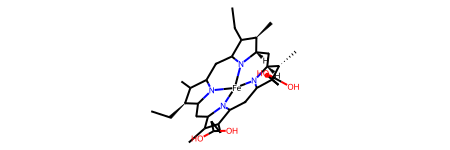

In [29]:
mol

Molecular Properties:
Number of atoms: 43
Number of bonds: 50
Number of rings: 8
Ring sizes: [6, 6, 6, 6, 5, 5, 5, 5]
Molecular weight: 644.72
LogP: 3.64
H-bond donors: 4
H-bond acceptors: 8


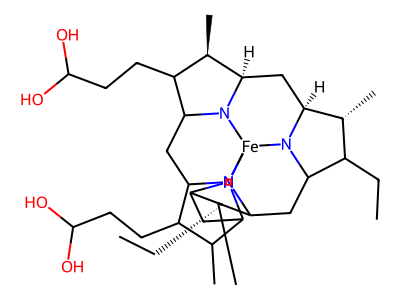

[]

In [31]:
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

# Calculate and display molecular information about the ligand

# Get molecule properties
num_atoms = mol.GetNumAtoms()
num_bonds = mol.GetNumBonds()
num_rings = mol.GetRingInfo().NumRings()
mol_weight = Descriptors.MolWt(mol)
logp = Chem.Descriptors.MolLogP(mol)
num_h_donors = Chem.Descriptors.NumHDonors(mol)
num_h_acceptors = Chem.Descriptors.NumHAcceptors(mol)

# Get ring information
ring_info = mol.GetRingInfo()
ring_sizes = [len(ring) for ring in ring_info.AtomRings()]

print(f"Molecular Properties:")
print(f"Number of atoms: {num_atoms}")
print(f"Number of bonds: {num_bonds}")
print(f"Number of rings: {num_rings}")
print(f"Ring sizes: {ring_sizes}")
print(f"Molecular weight: {mol_weight:.2f}")
print(f"LogP: {logp:.2f}")
print(f"H-bond donors: {num_h_donors}")
print(f"H-bond acceptors: {num_h_acceptors}")

# Generate 2D coordinates and create an image of the molecule
AllChem.Compute2DCoords(mol)
img = Draw.MolToImage(mol, size=(400, 300), kekulize=True, wedgeBonds=True, highlightAtoms=[])
display(img)
#get the atoms in aromatic rings
aromatic_atoms = [atom for atom in mol.GetAtoms() if atom.GetIsAromatic()]
aromatic_atoms

In [25]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.AtomPairs import Pairs

smiles = 'FC(F)(C(F)(C(O)=O)F)C(F)(F)F'


molecule = Chem.MolFromSmiles(smiles)
AllChem.ComputeGasteigerCharges(mol)

for atom in mol.GetAtoms():
    prop = atom.GetProp('_GasteigerCharge')
    print ( '%s | %s' % (atom.GetSymbol(), prop))

C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
O | -nan
O | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
C | -nan
O | -nan
O | -nan
N | -nan
N | -nan
N | -nan
N | -nan
Fe | -nan


In [26]:
atom.GetPropsAsDict()

{'_chiralPermutation': 3,
 '__computedProps': <rdkit.rdBase._vectclass std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > at 0x1fd5fc4cc40>,
 '_GasteigerCharge': nan,
 '_GasteigerHCharge': 0.0}